# Оценка качества изображений

**Постановка задачи**: Фотографии загружаемые поставщиками WB имеют разное качество: На одних может быть сложный фон, на каких-то фотографиях часть объекта не попала в кадр и.т.п. Для последующей работы с такими данными, например при использовании алгоритмов поиска по фото надо знать типs дефектов/овособенностей которые присутствуют на изображении.

<img src ="https://ml.gan4x4.ru/wb/quality/content/samples.png" width="800">


Всего 6 типов особенностей:  

* untidy,
* angle-composition,
* background,
* crop,
* text,
* multiple-objects

и один класс для изображений без дефектов
* good-image.

При этом изображение может содержать несколько видов дефектов.


Задача:

Требуется создать модель которая будет определять список дефектов для для изображения.

# Данные

По [ссылке](https://ml.gan4x4.ru/wb/quality/5000/student_5000.zip) доступен архив содержащий 5000 изображений и разметку.

Оригинальные изображения имели размер 900x1200 в датасете их разрешение уменьшено вдвое. Кроме изображений в архиве находиться csv файл c разметкой.
В первой колонке имя файла с изображением (без расширения), в остальных колонках названия классов к которым относиться изображение:

```
  18715,text,multiple-objects,,
  5259,text,background,,
  8932,background,,,
  ...

```

# Порядок выполнения задания

Задание рекомендуется выполнять по шагам:

1. Познакомьтесь с данными
2. Выберите метрику для оценки результата
3. Проведите анализ состояния вопроса, изучите существующие модели которые можно использовать для решения задачи
4. Проведите EDA, опишите особенности данных и проблемы которые они могут за собой повлечь
5. Подготовьте данные для обучения
6. Выберите baseline модель, оцените качество её работы на данном датасете.
7. Попробуйте улучшить значение метрики используя другую модель. Возможно обучив/дообучив ее.
8. Оцените быстродействие выбранной модели
9. Дайте оценку полученному результату.


**Важно!**

Блокнот должен содержать весь необходимый код для запуска финальной модели. Если для запуска требуется подгрузка весов, все ссылки длжны работать не только в вашем аккаунте но и в аккаунте преподавателя.

## Import libraries | Set Configs | Implementation classes

In [31]:
# --------------Libraries --------------- #


import os, re, gc
import sys,time,random
from typing import Any, Optional, Tuple, Union, Callable
# from numba import jit , cuda
import numpy as np
import pandas as pd
import shutil
import pathlib
import pickle
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, multilabel_confusion_matrix, classification_report, ConfusionMatrixDisplay
from mlcm import mlcm

import PIL
import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader , Dataset, Subset
from torch.optim import AdamW
import torchvision
from torchvision import models
from torchvision.transforms import v2
from torchvision.datasets import vision

import timm
import clearml

import pytorch_lightning as pl
from lightning import LightningModule, Trainer, LightningDataModule
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

torch.set_float32_matmul_precision('high')
print("Done!")

Done!


In [32]:
# ---Configuration class contains training configs---- #
#                                                      #
#                  &  model configs                    #
# ---------------------------------------------------- #

class Config:
        BATCH_SIZE = 32
        KFOLD = 5
        FOLD = 0
        SEED = 21
        LEARNING_RATE = 8e-6
        TYPE  = "Multi-label Image Classification"
        DATA_SOURCE = "multi-label-image-classification-dataset"
        MODEL_NAME = 'resnetv2_50'
        CRITERION_ = "Binary Cross Entropy"
        OPTIMIZER_ = "AdamW"
        DATA_TYPE = 'image'
        
        IMG_SIZE = (384,384)
        EPOCHS = 10
       
        
        def __init__(self):
            print("configuration set!")
        
        def check_cuda(self):
            print("Scanning for CUDA")
            if torch.cuda.is_available():
                print("GPU is available , training will be accelerated! : )\n")
            else:
                print("NO GPUs found : / \n")
        
        def seed_everything(self):
            print("Seeding...")
            np.random.seed(self.SEED)
            random.seed(self.SEED)
            os.environ['PYTHONHASHSEED'] = str(self.SEED)
            torch.manual_seed(self.SEED)
            torch.cuda.manual_seed(self.SEED)
            torch.backends.cudnn.deterministic = True
            torch.backends.cudnn.benchmark = False
            print("Seeded everything!")

CFG = Config()
CFG.check_cuda()
CFG.seed_everything()

configuration set!
Scanning for CUDA
GPU is available , training will be accelerated! : )

Seeding...
Seeded everything!


In [33]:
class Wildberries5000(vision.VisionDataset):
    """`Wildberries products <https://ml.gan4x4.ru/wb/quality/5000/student_5000.zip>`_ Dataset.

    Args:
        root (str or ``pathlib.Path``): Root directory of dataset where directory
            ``student_5000.zip`` exists or will be saved to if download is set to True.
        train (bool, optional): If True, creates dataset from training set, otherwise
            creates from test set.
        transform (callable, optional): A function/transform that takes in a PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
        download (bool, optional): If true, downloads the dataset from the internet and
            puts it in root directory. If dataset is already downloaded, it is not
            downloaded again.

    """

    url = "https://ml.gan4x4.ru/wb/quality/5000/student_5000.zip"
    filename = "student_5000.zip"
    data_format = '.jpg'
    

    def __init__(
        self,
        root: Union[str, pathlib.Path] = '',
        train: bool = True,
        split: float = 0.3,
        transform: Optional[Callable] = None,
        download: bool = False,
    ) -> None:

        super().__init__(root, transform=transform)
        self.train_csv_path = pathlib.Path(self.root, "./5000/5000.csv")
        self.train_dir = pathlib.Path(self.root, "./5000/images/")
        self.train = train  # training set or test set

        if download:
            self.download()

        if not self._check_integrity():
            raise RuntimeError("Dataset not found or corrupted. You can use download=True to download it")

        index = (f'{self.train_dir}/' \
            + pd.read_csv(self.train_csv_path, header=None, usecols=[0], dtype=str) \
            + Wildberries5000.data_format)[0]

        targets = pd.read_csv(self.train_csv_path, header=None, usecols = [1,2,3,4], keep_default_na=False)
        targets = targets.apply(' '.join , axis=1)
        targets = targets.str.strip()

        self.full_dataset: pd.DataFrame = pd.DataFrame({'index': index, 'targets': targets})
        self.full_dataset = self.full_dataset.loc[~self.full_dataset["index"].isin(self.data_sanity_check())]

        self.targets_list = self.full_dataset['targets'].apply(lambda x: x.split())

        self.mlb = MultiLabelBinarizer().fit(self.targets_list)
        self.one_hot_targets = pd.DataFrame(self.mlb.transform(self.targets_list), columns=self.mlb.classes_)
        self.full_dataset[self.one_hot_targets.columns] =  self.one_hot_targets

        train_data, test_data = train_test_split(self.full_dataset, test_size=split, random_state=CFG.SEED)
        self.data = train_data if self.train else test_data


    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """
            Args:
                idx (int): Index

            Returns:
                tuple: (image, target) where target is one-hot-encoded vector of the target classes.
        """
        img = cv2.imread(self.data.iloc[idx,0])
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img = img / 255.
        img = torch.Tensor(img).permute([2,1,0]) # convert to HWC
        
        label = self.data.iloc[idx, 2:].astype(np.int8).values
        label = torch.Tensor(label)

        if self.transform:                                
            return self.transform(img), label
        return img, label
    


    

    def __len__(self) -> int:
        return len(self.data)

    def _check_integrity(self) -> bool:
        return os.path.isfile(pathlib.Path(self.root, Wildberries5000.filename))

    def download(self) -> None:
        if self._check_integrity():
            print("Files already downloaded")
            return

        pathlib.Path(self.root).mkdir(parents=True, exist_ok=True)
        os.system(f'wget {Wildberries5000.url} -o {pathlib.Path(self.root, self.filename)}')
        os.system(f'unzip {Wildberries5000.filename} -d {self.root}')
        

    def extra_repr(self) -> str:
        split = "Train" if self.train is True else "Test"
        return f"Split: {split}"
    
    def data_sanity_check(self):
        """
            this will check each image file for corrupted or missing and 
            returns index of corrupted / missing files .Doing this will
            prevent us from running into any data errors during training phase .
        """
        idx = []
        start = time.time()
        for i in range(len(self.full_dataset)):
            try:#       checks for corrupeted or missing image files
                if len(cv2.imread(self.full_dataset.iloc[i,0])) == 3:
                    _ = 1
            except:
                idx.append(self.full_dataset.iloc[i,0])
        end = time.time()
        print(end-start)
        _ = gc.collect()
        print(idx)
        return idx

In [34]:
class WBData(LightningDataModule):
    
    debug = True
    
    def __init__(self, dataset_class: torch.utils.data.Dataset, 
                 batch_size=32, 
                 train_transform=None, val_transform=None):
        super().__init__()
        
        params = dict(root=pathlib.Path(os.getcwd()) / "content", 
                      download=True)
        
        self.train = dataset_class(train=True, transform=train_transform, split=0.3, **params)
        dev = dataset_class(train=False, transform=val_transform, split=0.3, **params)
        self.val, self.test = train_test_split(dev, test_size=0.3, random_state=CFG.SEED)

        self.batch_size = batch_size
        
    
    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.train, shuffle=True, 
                          batch_size=self.batch_size, num_workers=100)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.val, shuffle=False, 
                          batch_size=self.batch_size, num_workers=100)
        
    def test_dataloader(self):
        return torch.utils.data.DataLoader(self.test, batch_size=1, shuffle=False, num_workers=100)

# Анализ данных (EDA)

In [35]:
df = WBData(Wildberries5000, Config.BATCH_SIZE)

Files already downloaded
4.647738456726074
[]
Files already downloaded
3.9216842651367188
[]


<Axes: title={'center': 'Target Class Distribution'}>

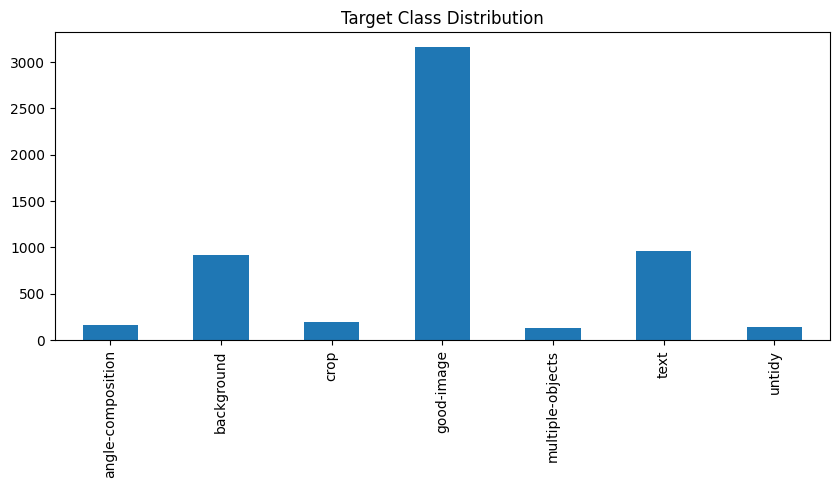

In [36]:
fig, ax = plt.subplots(figsize=(10, 4))
df.train.one_hot_targets.sum().plot.bar(title='Target Class Distribution')

- 60% составляют изображения без особенностей
- по 20% от всего датасета составляют изображения с фоном или с текстом
- остальные 40% изображений имеют особенности "композиции", "обрезки", "множества объектов" и "неаккуратности" (~= по 5%)

<Axes: title={'center': 'Distribution of Number of Labels per Image'}>

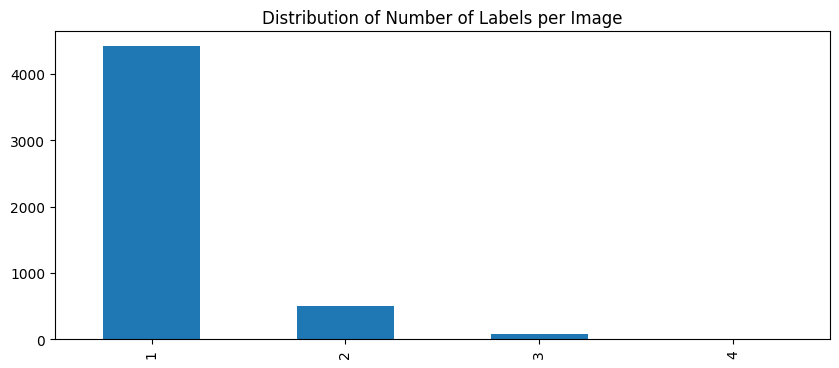

In [37]:
fig, ax = plt.subplots(figsize=(10, 4))
df.train.one_hot_targets.sum(axis=1).value_counts().plot.bar(title='Distribution of Number of Labels per Image')

- 88% изображений присвоена 1 метка (72% из которых принадлежат изображениям "без особенностей")
- только 1% изображений имеет по 2 метки
- 1,5% изображений имеют по 3 метки
- 0,08% изображений присвоено 4 метки

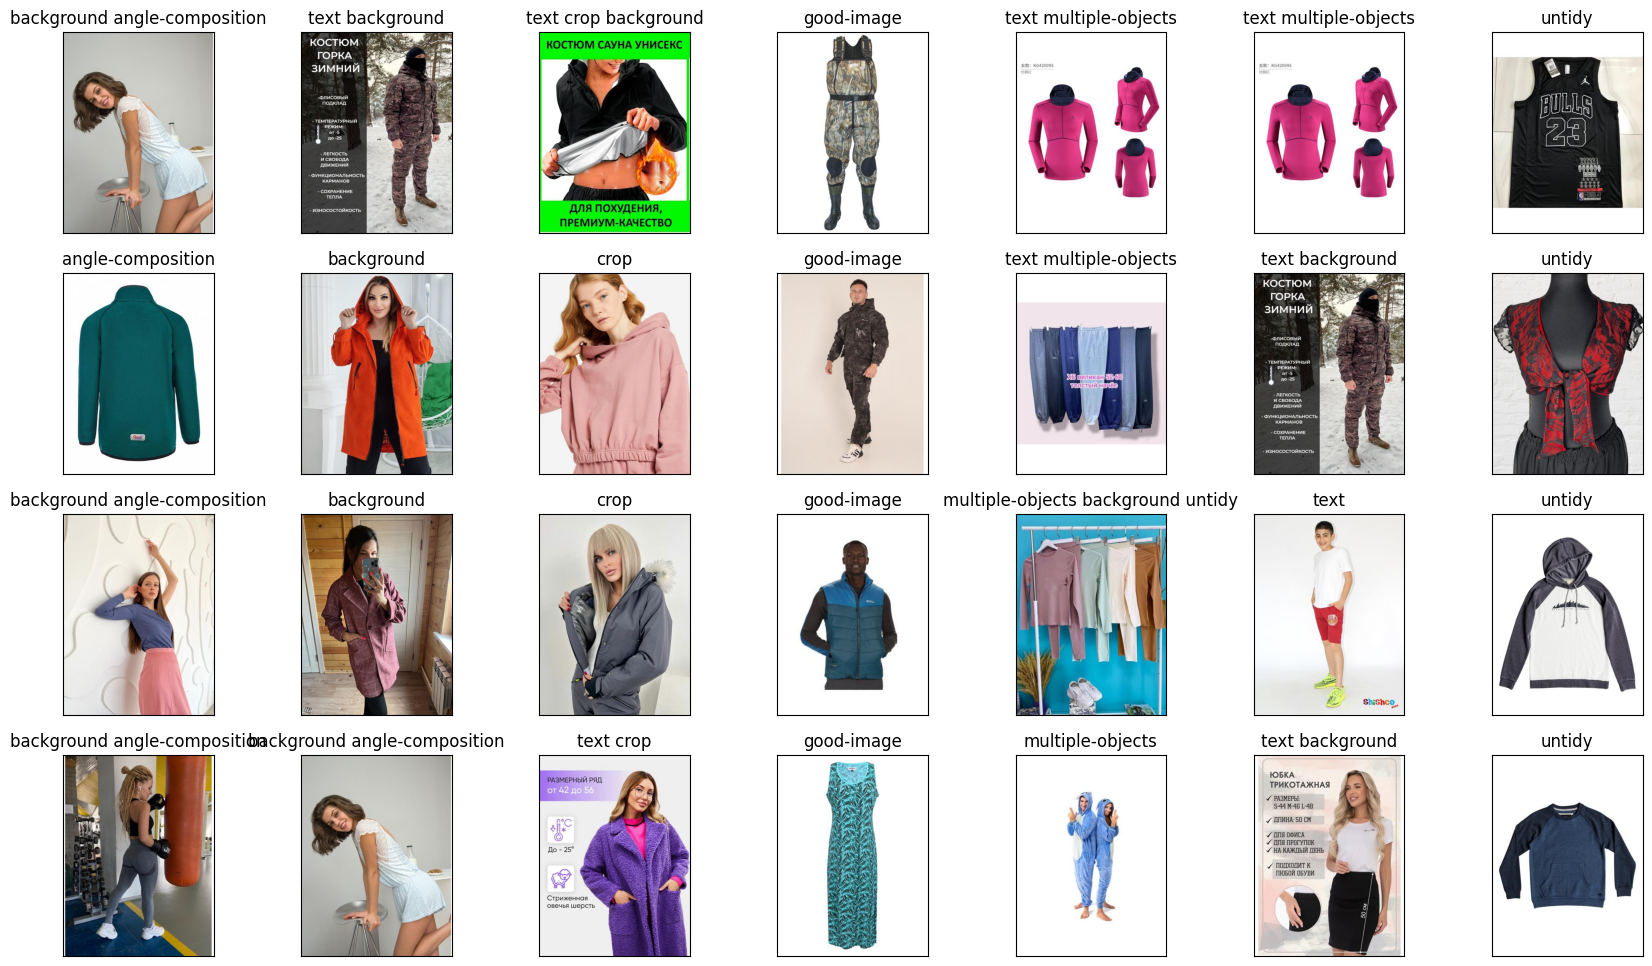

In [38]:
def plot_img_grid(rows, df, classes):
    fig = plt.figure(figsize=(3*len(classes), 3*rows))

    
    for cl_idx, cl in enumerate(classes):
        df_cl = df.loc[df[cl] == 1].iloc[:rows]
        for idx in range(len(df_cl)):
            img = cv2.cvtColor(cv2.imread(df_cl.iloc[idx,0]), cv2.COLOR_BGR2RGB)
            ax = fig.add_subplot(rows, len(classes), idx*len(classes)+cl_idx + 1)
            ax.title.set_text(df_cl.iloc[idx,1])
            plt.xticks([]) ; plt.yticks([]) 
            plt.imshow(img)
    plt.show()

plot_img_grid(4, df.train.full_dataset, classes=df.train.mlb.classes_)

1. angle-composition - включает фотографии позирующих моделей (в т.ч. снятых сзади), либо одежды/обуви, снятой с нетипичного ракурса (сверху, сзади, на ноге)
2. background - фотографии, снятые не на белом фоне - т.е. с естественным фоном комнаты/улицы или с искуственным фоном
3. crop - включает фотографии, где обрезан сам товар (на модели или без нее)
4. good-image - модели стоят прямо перед камерой, фон белый, товар показан полностью (или в случае обуви наполовину -  1 ботинок, 1 босоножка). Среди размеченных этого класса фото были найдены фото с серым фоном, с позирующими моделями 
5. multiple-objects - фотографии с множеством объектов (одного и того же товара в разных ракурсах, одного товара в разной расцветке, на разных моделях), а также с миниатюрой/ами в углу фотографии этого товара
6. text - фотографии, содержащие текст, логотипы, значки
7. untidy - неопрятный товар на фотографии (непроглаженный, неаккуратно уложенный) или снятый не в студийных условиях/при плохом освещении

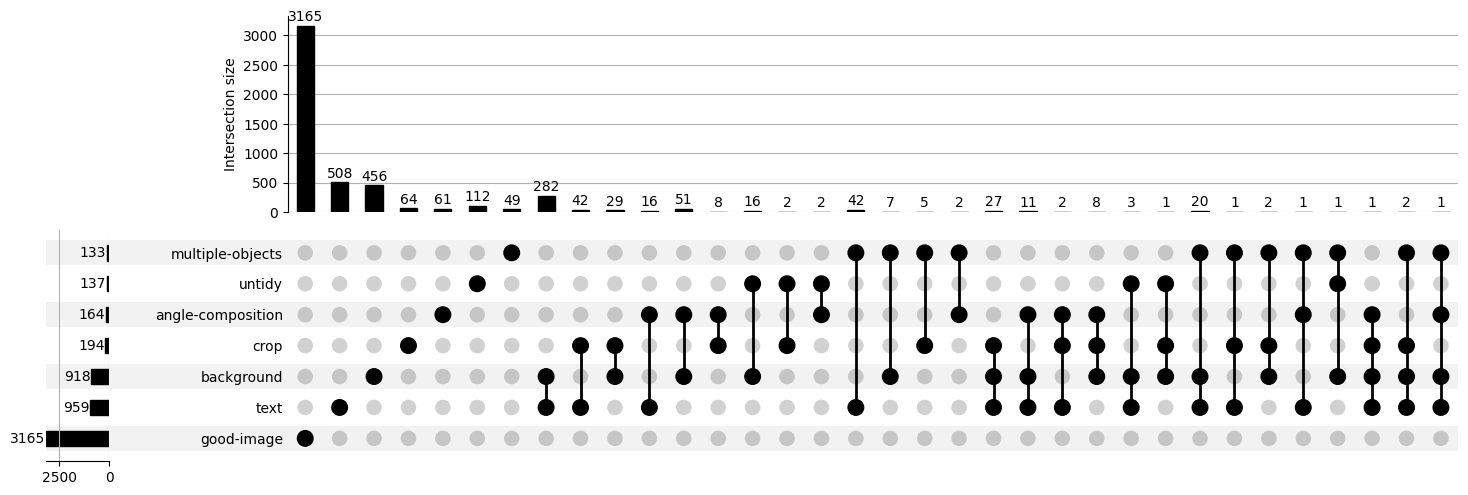

In [39]:
%%capture --no-display
from upsetplot import from_memberships, UpSet

ax_dict = UpSet(from_memberships(df.train.targets_list, data=df.train.full_dataset), 
                subset_size="count", show_counts=True).plot()

Топ 5 самый частых сочетаний меток на изображениях:
- 3165 - good_image
- 508 - text
- 456 - background
- 282 - text+background
- 112 - untidy

# Baseline

## Calculate mean/std

In [40]:
class ImageData(vision.VisionDataset):
    
    url = "https://ml.gan4x4.ru/wb/quality/5000/student_5000.zip"
    filename = "student_5000.zip"
    data_format = '.jpg'
    

    def __init__(
        self,
        root: Union[str, pathlib.Path] = '',
        split: float = 0.3,
        transform: Optional[Callable] = None,
    ) -> None:

        super().__init__(root, transform=transform)
        self.train_csv_path = pathlib.Path(self.root, "./5000/5000.csv")
        self.train_dir = pathlib.Path(self.root, "./5000/images/")

        index = (f'{self.train_dir}/' \
            + pd.read_csv(self.train_csv_path, header=None, usecols=[0], dtype=str) \
            + Wildberries5000.data_format)[0]

        targets = pd.read_csv(self.train_csv_path, header=None, usecols = [1,2,3,4], keep_default_na=False)
        targets = targets.apply(' '.join , axis=1)
        targets = targets.str.strip()

        self.full_dataset: pd.DataFrame = pd.DataFrame({'index': index, 'targets': targets})

        self.targets_list = self.full_dataset['targets'].apply(lambda x: x.split())

        self.mlb = MultiLabelBinarizer().fit(self.targets_list)
        self.one_hot_targets = pd.DataFrame(self.mlb.transform(self.targets_list), columns=self.mlb.classes_)
        self.full_dataset[self.one_hot_targets.columns] =  self.one_hot_targets

        train_data, _ = train_test_split(self.full_dataset, test_size=split, random_state=CFG.SEED)
        self.data = train_data


    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        img_path = self.data.iloc[idx, 0]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = self.transform(image=img)['image']
        return img

    def __len__(self) -> int:
        return len(self.data)


In [41]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

augs = A.Compose(
    [
        A.Resize(height=512, width=512),
        A.Normalize(mean=(0, 0, 0), std=(1, 1, 1)),
        ToTensorV2(),
    ]
)

In [42]:
# dataset
image_dataset = ImageData(transform=augs, split=0.3, root=pathlib.Path(os.getcwd()) / "content")

# data loader
image_loader = DataLoader(
    image_dataset,
    batch_size=128,
    shuffle=False,
    num_workers=8,
    pin_memory=True,
)

In [43]:
####### COMPUTE MEAN / STD

# placeholders
psum = torch.tensor([0.0, 0.0, 0.0])
psum_sq = torch.tensor([0.0, 0.0, 0.0])

# loop through images
for inputs in tqdm(image_loader):
    psum += inputs.sum(axis=[0, 2, 3])
    psum_sq += (inputs**2).sum(axis=[0, 2, 3])

####### FINAL CALCULATIONS

# pixel count
count = len(image_dataset) * 512 * 512

# mean and std
total_mean = psum / count
total_var = (psum_sq / count) - (total_mean**2)
total_std = torch.sqrt(total_var)

# output
print("mean: " + str(total_mean))
print("std:  " + str(total_std))

  0%|          | 0/28 [00:00<?, ?it/s]

mean: tensor([0.7600, 0.7383, 0.7361])
std:  tensor([0.3072, 0.3159, 0.3164])


In [44]:
# TODO: настроить аугментацию:
# specify image transforms for augmentation during training
train_transform = v2.Compose([
    v2.RandomHorizontalFlip(p=0.5),
    v2.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0),
    v2.RandomAffine(degrees=20, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=None),
    v2.Resize((224, 224)),
    v2.Normalize(total_mean, total_std),
])

# во время проверки мы используем только тензорные и нормализационные преобразования
val_transform = v2.Compose([
    v2.Resize((224, 224)),
    v2.Normalize(total_mean, total_std),
])

In [45]:
df = WBData(Wildberries5000, Config.BATCH_SIZE, 
            train_transform=train_transform, val_transform=val_transform
            )

Files already downloaded
4.9997780323028564
[]
Files already downloaded
3.925720453262329
[]


## Model

In [46]:
class MLCNNet(nn.Module):
    
    def __init__(self,backbone,n_classes):
        super(MLCNNet,self).__init__();
        self.model = backbone
        for param in self.model.parameters():
            param.requires_grad = False

        num_features = backbone.stages[3].blocks[2].conv3.out_channels
        
        # Additional linear layer and dropout layer
        self.classifier = nn.Sequential(nn.Linear(num_features,256),
                                            nn.ReLU(),
                                            nn.Dropout(0.5),
                                            nn.Linear(256,n_classes))
       
    def forward(self,x):
        x = self.model(x)
        x = self.classifier(x)
        return x

In [61]:
class LitMLCNet(pl.LightningModule):
    
    def __init__(self,model):
        super().__init__();
        self.model = model

    def layer_summary(self, X_shape):
        
        print(f"{'Размер входного тензора':25}:\t{X_shape}") 
        X = torch.randn(*X_shape)
        for layer in self.model:
            X = layer(X)
            print(f"{layer.__class__.__name__:25}:\t{list(X.shape)}", )


    def eval_loss(self, batch, batch_idx, mode):
        x,y = batch
        outputs = self.model(x)
        loss = F.binary_cross_entropy_with_logits(outputs, y, pos_weight=torch.tensor([1, 1, 1, 0.5, 1, 1, 1], device='cuda'))
        self.log(f"{mode}/loss", loss.item() / len(y), prog_bar=True, on_epoch=True)
        return loss
    
    def eval_score(self, batch, batch_idx, mode):
        x,y = batch
        preds  = self.model(x)
        preds_labels = preds, y

        preds,labels =[],[]
        for item in preds_labels:
            preds.append(torch.round(torch.sigmoid(item[0][0])).detach().cpu().numpy().tolist())
            labels.append(item[1][0].detach().cpu().numpy().tolist())
        self.log(f"{mode}/accuracy", accuracy_score(preds,labels), prog_bar=True, on_epoch=True)
    
    def training_step(self,batch,batch_idx):
        # self.eval_score(batch, batch_idx, 'train')
        return self.eval_loss(batch, batch_idx, 'train')
        
    
    def validation_step(self,batch,batch_idx):
        self.eval_loss(batch, batch_idx, 'val')
        # self.eval_score(batch, batch_idx, 'val')
    
    def predict_step(self, batch, batch_idx,dataloader_idx=0):
        x,y = batch
        preds  = self.model(x)
        return preds,y
    
    def configure_optimizers(self):
        optim = torch.optim.AdamW(self.parameters(),lr = 8e-5)
        return optim

In [48]:
timm.list_models("resnet*")

['resnet10t',
 'resnet14t',
 'resnet18',
 'resnet18d',
 'resnet26',
 'resnet26d',
 'resnet26t',
 'resnet32ts',
 'resnet33ts',
 'resnet34',
 'resnet34d',
 'resnet50',
 'resnet50_clip',
 'resnet50_clip_gap',
 'resnet50_gn',
 'resnet50_mlp',
 'resnet50c',
 'resnet50d',
 'resnet50s',
 'resnet50t',
 'resnet50x4_clip',
 'resnet50x4_clip_gap',
 'resnet50x16_clip',
 'resnet50x16_clip_gap',
 'resnet50x64_clip',
 'resnet50x64_clip_gap',
 'resnet51q',
 'resnet61q',
 'resnet101',
 'resnet101_clip',
 'resnet101_clip_gap',
 'resnet101c',
 'resnet101d',
 'resnet101s',
 'resnet152',
 'resnet152c',
 'resnet152d',
 'resnet152s',
 'resnet200',
 'resnet200d',
 'resnetaa34d',
 'resnetaa50',
 'resnetaa50d',
 'resnetaa101d',
 'resnetblur18',
 'resnetblur50',
 'resnetblur50d',
 'resnetblur101d',
 'resnetrs50',
 'resnetrs101',
 'resnetrs152',
 'resnetrs200',
 'resnetrs270',
 'resnetrs350',
 'resnetrs420',
 'resnetv2_50',
 'resnetv2_50d',
 'resnetv2_50d_evos',
 'resnetv2_50d_frn',
 'resnetv2_50d_gn',
 'resnetv2

In [58]:
backbone = timm.create_model("resnetv2_50", pretrained=True, num_classes=0)
backbone

INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/resnetv2_50.a1h_in1k)
INFO:timm.models._hub:[timm/resnetv2_50.a1h_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


ResNetV2(
  (stem): Sequential(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (stages): Sequential(
    (0): ResNetStage(
      (blocks): Sequential(
        (0): PreActBottleneck(
          (downsample): DownsampleConv(
            (conv): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (norm): Identity()
          )
          (norm1): BatchNormAct2d(
            64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): ReLU(inplace=True)
          )
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNormAct2d(
            64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): ReLU(inplace=True)
          )
          (conv2): Conv2d(64, 64, kernel_size=

In [63]:
Model = MLCNNet(backbone, n_classes=7)
pl_Model = LitMLCNet(Model)
pl_Model

LitMLCNet(
  (model): MLCNNet(
    (model): ResNetV2(
      (stem): Sequential(
        (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      )
      (stages): Sequential(
        (0): ResNetStage(
          (blocks): Sequential(
            (0): PreActBottleneck(
              (downsample): DownsampleConv(
                (conv): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (norm): Identity()
              )
              (norm1): BatchNormAct2d(
                64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
                (drop): Identity()
                (act): ReLU(inplace=True)
              )
              (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (norm2): BatchNormAct2d(
                64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
   

In [51]:
for name, param in pl_Model.named_parameters():
    if 'conv1' in name or 'layer1' in name or 'fc' in name:
        print(name, param.shape)

model.model.stages.0.blocks.0.conv1.weight torch.Size([64, 64, 1, 1])
model.model.stages.0.blocks.1.conv1.weight torch.Size([64, 256, 1, 1])
model.model.stages.0.blocks.2.conv1.weight torch.Size([64, 256, 1, 1])
model.model.stages.1.blocks.0.conv1.weight torch.Size([128, 256, 1, 1])
model.model.stages.1.blocks.1.conv1.weight torch.Size([128, 512, 1, 1])
model.model.stages.1.blocks.2.conv1.weight torch.Size([128, 512, 1, 1])
model.model.stages.1.blocks.3.conv1.weight torch.Size([128, 512, 1, 1])
model.model.stages.2.blocks.0.conv1.weight torch.Size([256, 512, 1, 1])
model.model.stages.2.blocks.1.conv1.weight torch.Size([256, 1024, 1, 1])
model.model.stages.2.blocks.2.conv1.weight torch.Size([256, 1024, 1, 1])
model.model.stages.2.blocks.3.conv1.weight torch.Size([256, 1024, 1, 1])
model.model.stages.2.blocks.4.conv1.weight torch.Size([256, 1024, 1, 1])
model.model.stages.2.blocks.5.conv1.weight torch.Size([256, 1024, 1, 1])
model.model.stages.3.blocks.0.conv1.weight torch.Size([512, 102

In [64]:
trainer = pl.Trainer(
        max_epochs=20,
        accelerator='gpu',
        devices=1,
        callbacks=[EarlyStopping(monitor="val/loss", mode="min", patience=5)]
    )

# %load_ext tensorboard
# %tensorboard --logdir ./lightning_logs

task = clearml.Task.init(project_name='WB intership', task_name='multi-label classification')
trainer.fit(model=pl_Model,
            train_dataloaders=df.train_dataloader(),
            val_dataloaders=df.val_dataloader())
task.close()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name  | Type    | Params
----------------------------------
0 | model | MLCNNet | 24.0 M
----------------------------------
526 K     Trainable params
23.5 M    Non-trainable params
24.0 M    Total params
96.107    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa7ff580790>
Traceback (most recent call last):
  File "/home/prog3/.cache/pypoetry/virtualenvs/intership-opmGnuy9-py3.10/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/home/prog3/.cache/pypoetry/virtualenvs/intership-opmGnuy9-py3.10/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1443, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.10/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.10/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.10/selectors.py", line 416, in select
    fd_event_list = self._selector.poll(timeout)
KeyboardIn

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/home/prog3/.cache/pypoetry/virtualenvs/intership-opmGnuy9-py3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:54: UserWarning:

Detected KeyboardInterrupt, attempting graceful shutdown...



# Метрики

In [ ]:
preds_labels = trainer.predict(pl_Model, df.test_dataloader())


preds,labels =[],[]
for item in preds_labels:
    preds.append(torch.round(torch.sigmoid(item[0][0])).detach().cpu().numpy().tolist())
    labels.append(item[1][0].detach().cpu().numpy().tolist())

In [ ]:
print(f"test_accuracy  - {accuracy_score(preds,labels)}")

In [ ]:
# Матрица ошибок с помощью mlcm:
# последняя строка/столбец NoC (No class) - объекту не сопоставлен ни один из классов
conf_mat, normal_conf_mat = mlcm.cm(labels, preds)

fig = plt.figure(figsize=(20, 20))
matrix_classes = np.append(df.train.mlb.classes_, 'NoC')

ax1 = fig.add_subplot(2,2,1)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=matrix_classes)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=90, ax=ax1)
plt.title('Raw confusion Matrix:')

ax2 = fig.add_subplot(2,2,2)
disp = ConfusionMatrixDisplay(confusion_matrix=normal_conf_mat, display_labels=matrix_classes)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=90, ax=ax2)
plt.title('Normalized confusion Matrix (%)')

plt.show()

In [ ]:
%%capture --no-stdout
stats = mlcm.stats(conf_mat, print_binary_mat=False)

In [ ]:
len(df.test)

In [ ]:
fig = plt.figure(figsize=(20, 20))

matrix_classes = np.append(df.train.mlb.classes_, 'NoC')

for idx, matrix in enumerate(stats, 1):
    ax = fig.add_subplot(4,4,idx)
    ax.title.set_text(matrix_classes[idx-1])
    confusion_matrix = ConfusionMatrixDisplay(confusion_matrix=matrix)
    confusion_matrix.plot(ax=ax, cmap=plt.cm.Blues)
    
plt.show()

## Решение

In [ ]:
# Put your code here

## Оценка результата

In [ ]:
# Put your code here

## Вывод

...

# Тестовый блок для проверки

Поместите сюда весь необходимый код для тестирования вашей модели на новых данных. Убедитесь что

- Импортируются все библиотеки и классы
- Подгружабтся веса с внешних ресурсов
- Происходит рассчет метрик
...

In [ ]:
# Put your code here